https://github.com/grf-labs/grf

In [1]:
install.packages("grf")

also installing the dependencies ‘zoo’, ‘DiceKriging’, ‘lmtest’, ‘sandwich’




The downloaded binary packages are in
	/var/folders/8b/hhnbt0nd4zsg2qhxc28q23w80000gn/T//Rtmp1Ezmv5/downloaded_packages


In [2]:
library(grf)

# Generate data.
n = 2000; p = 10
X = matrix(rnorm(n*p), n, p)
X.test = matrix(0, 101, p)
X.test[,1] = seq(-2, 2, length.out = 101)

In [3]:
# Train a causal forest.
W = rbinom(n, 1, 0.4 + 0.2 * (X[,1] > 0))
Y = pmax(X[,1], 0) * W + X[,2] + pmin(X[,3], 0) + rnorm(n)
tau.forest = causal_forest(X, Y, W)


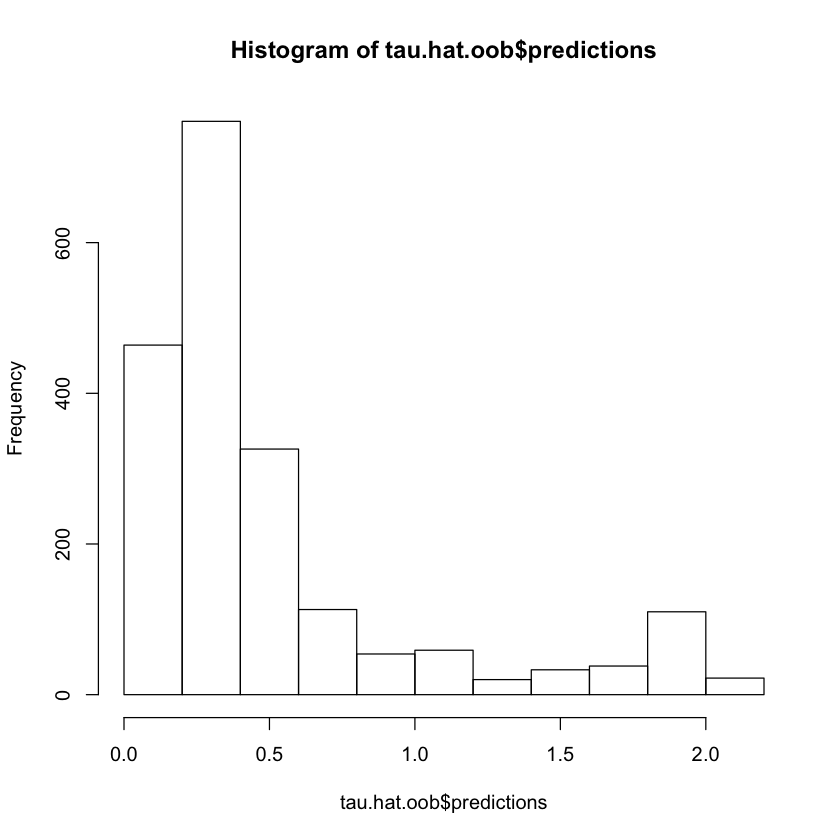

In [4]:
# Estimate treatment effects for the training data using out-of-bag prediction.
tau.hat.oob = predict(tau.forest)
hist(tau.hat.oob$predictions)

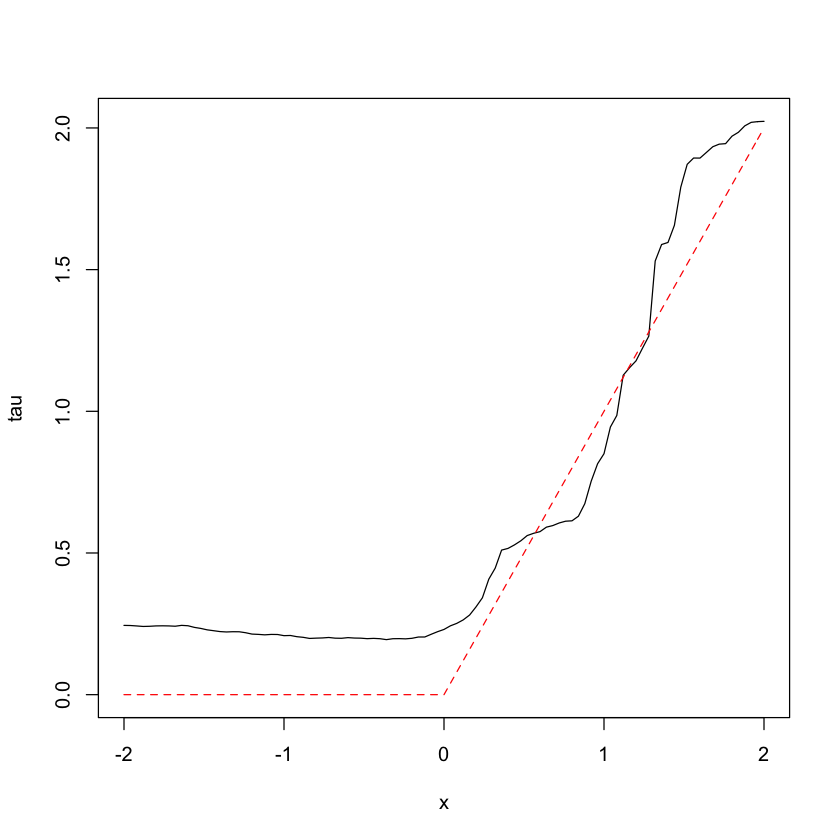

In [5]:
# Estimate treatment effects for the test sample.
tau.hat = predict(tau.forest, X.test)
plot(X.test[,1], tau.hat$predictions, ylim = range(tau.hat$predictions, 0, 2), xlab = "x", ylab = "tau", type = "l")
lines(X.test[,1], pmax(0, X.test[,1]), col = 2, lty = 2)


In [6]:
# Estimate the conditional average treatment effect on the full sample (CATE).
average_treatment_effect(tau.forest, target.sample = "all")


estimate    std.err 
0.51496883 0.04922084

estimate    std.err 
0.61763715 0.04998598

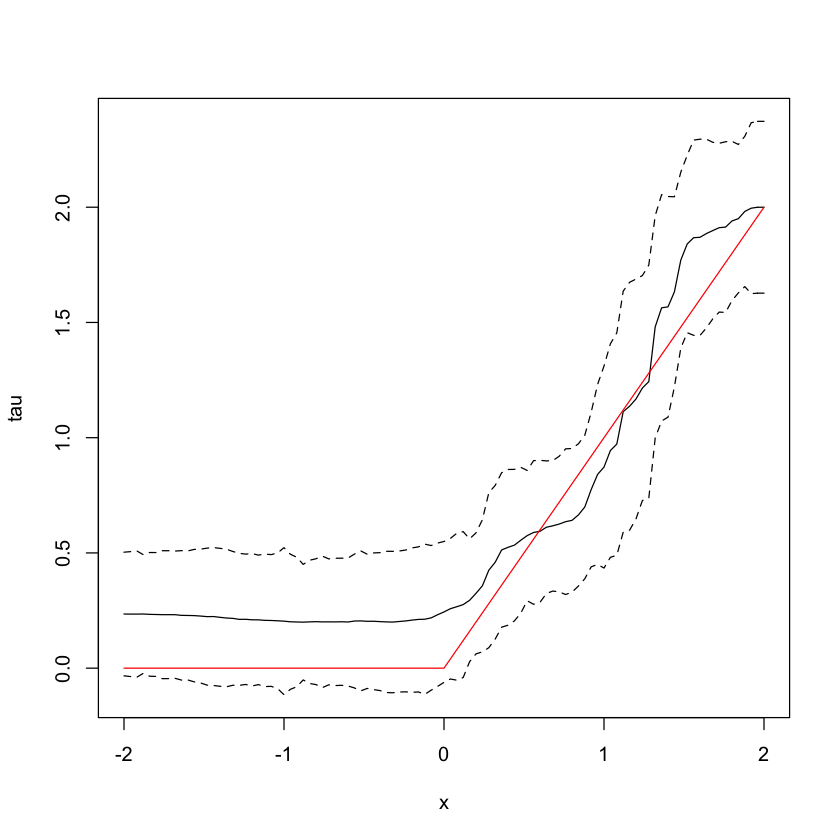

In [7]:
# Estimate the conditional average treatment effect on the treated sample (CATT).
# Here, we don't expect much difference between the CATE and the CATT, since
# treatment assignment was randomized.
average_treatment_effect(tau.forest, target.sample = "treated")

# Add confidence intervals for heterogeneous treatment effects; growing more trees is now recommended.
tau.forest = causal_forest(X, Y, W, num.trees = 4000)
tau.hat = predict(tau.forest, X.test, estimate.variance = TRUE)
sigma.hat = sqrt(tau.hat$variance.estimates)
plot(X.test[,1], tau.hat$predictions, ylim = range(tau.hat$predictions + 1.96 * sigma.hat, tau.hat$predictions - 1.96 * sigma.hat, 0, 2), xlab = "x", ylab = "tau", type = "l")
lines(X.test[,1], tau.hat$predictions + 1.96 * sigma.hat, col = 1, lty = 2)
lines(X.test[,1], tau.hat$predictions - 1.96 * sigma.hat, col = 1, lty = 2)
lines(X.test[,1], pmax(0, X.test[,1]), col = 2, lty = 1)

In some examples, pre-fitting models for Y and W separately may be helpful (e.g., if different models use different covariates).

In some applications, one may even want to get Y.hat and W.hat using a completely different method (e.g., boosting).

In [8]:
# Generate new data.
n = 4000; p = 20
X = matrix(rnorm(n * p), n, p)
TAU = 1 / (1 + exp(-X[, 3]))
W = rbinom(n ,1, 1 / (1 + exp(-X[, 1] - X[, 2])))
Y = pmax(X[, 2] + X[, 3], 0) + rowMeans(X[, 4:6]) / 2 + W * TAU + rnorm(n)

forest.W = regression_forest(X, W, tune.parameters = TRUE)
W.hat = predict(forest.W)$predictions

forest.Y = regression_forest(X, Y, tune.parameters = TRUE)
Y.hat = predict(forest.Y)$predictions

forest.Y.varimp = variable_importance(forest.Y)

In [9]:
# Note: Forests may have a hard time when trained on very few variables
# (e.g., ncol(X) = 1, 2, or 3). We recommend not being too aggressive
# in selection.
selected.vars = which(forest.Y.varimp / mean(forest.Y.varimp) > 0.2)

tau.forest = causal_forest(X[, selected.vars], Y, W,
                           W.hat = W.hat, Y.hat = Y.hat,
                           tune.parameters = TRUE)

# Check whether causal forest predictions are well calibrated.
test_calibration(tau.forest)


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value    Pr(>t)    
mean.forest.prediction         1.000553   0.067797 14.7580 < 2.2e-16 ***
differential.forest.prediction 0.904136   0.153726  5.8815 2.199e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
